In [1]:
%config Completer.use_jedi = False

In [2]:
from utils import *
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.constraint_handling import *
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "../datasets/UK50_1.txt"
meta_data, distance_data, station_data = parse_UK_Data(dataset)

#station_coordinates = generate_coordinates(station_data, to_csv=True, filename=dataset)
location_context = "United Kingdom"
#station_coordinates = generate_coordinates(station_data,location_context,to_csv=True,filename=dataset)
station_coordinates = pd.read_csv('../datasets/UK50_1_coordinates.csv', encoding='utf-8')
points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()

#UK = gpd.read_file("../datasets/united_kingdom_european_regions/Regions__December_2019__Boundaries_EN_BFC-shp/Regions__December_2019__Boundaries_EN_BFC.shp")
dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
dbf = dbf.to_crs("EPSG:4326")

In [3]:
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000
#distance_matrix_here,time_matrix_here,_ = generate_large_distance_matrix(points_coordinate,api)
distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/",dataset)

In [4]:
def cheapest_arc(nodes,start_positions,end_positions,transit_cost_function,cost_function_parameter_dict:dict):
    result = []
    if(end_positions != None):
        pickup_points = list(set(set(nodes) - set(end_positions)) - set(start_positions))
    else:
        pickup_points = list(set(nodes) - set(start_positions))
        
    ends = copy(end_positions)
    for start_pos in start_positions:
        result.append(start_pos)
        node_amount = int(len(pickup_points)/len(start_positions))
        
        closest_positions = sorted(pickup_points, key = lambda node: transit_cost_function(start_pos,node,**cost_function_parameter_dict))[:node_amount]
    
        for taken_position in closest_positions:
            pickup_points.remove(taken_position)
            result.append(taken_position)
        
        if len(ends) > 1:
            closest_end = sorted(ends, key = lambda node: transit_cost_function(result[-1],node,**cost_function_parameter_dict))[0]
        else:
            closest_end = ends[0]
        
        result.append(closest_end)
        ends.remove(closest_end)
        
        
        
    for node in pickup_points:
        if node not in result:
            result.insert(1,node)

    return result

def shuffle_paths(variables,starts,ends):
    #random.seed(1)
    result = []
    start_indices = []
    end_indices = []
    for start,end in zip(starts,ends):
        end_indices.append(variables.index(end))
        start_indices.append(variables.index(start))
    end_indices.sort()
    start_indices.sort()
    
    for start, end in zip(start_indices,end_indices):
        result.append(variables[start])
        result.extend(random.sample(variables[start+1:end],k=len(variables[start+1:end])))
        result.append(variables[end])

    return result
            


In [5]:
import math
import random
from jmetal.core.problem import PermutationProblem
from jmetal.core.solution import PermutationSolution
from itertools import chain
import collections
from bisect import bisect_left


class VRP(PermutationProblem):
    
    def __init__(self,problemData):
        check_type(problemData,dict)
        fuel_eq_types = {0:'linear',1:'rakha'}
        super(VRP,self).__init__()
        
        self.distance_matrix = problemData['distance_matrix']
        self.time_matrix = problemData['time_matrix']
        self.demands = problemData['demands']
        self.max_no_of_vehicle = problemData['vehicle_amount']
        self.vehicle_capacities = problemData['vehicle_capacities']
        self.object_directions=[self.MINIMIZE,self.MAXIMIZE]
        self.number_of_objectives = problemData['objective_amount']
        self.objective_functions=problemData['objective_functions']
        self.objective_labels = problemData['objective_labels']
        self.number_of_constraints = problemData['constraint_amount']
        self.constraint_functions= problemData['constraint_functions']
        self.start_positions = problemData['start_points']
        self.end_positions = problemData['end_points']
        self.number_of_variables = problemData['number_of_cities']
        self.depot = 0
        self.cost_history = []
        self.fuel_eq_type = fuel_eq_types[problemData['fuelEq']]
        self.name = 'VRP'
        self.assignClosestEndPoint = False
        
        
        
    def evaluate(self, solution: PermutationSolution) -> PermutationSolution:
        
        def split_paths(values,starts):
            result = []
            for start_index,start in enumerate(starts):
                index = values.index(start)
                if start_index == len(starts)-1:
                    result.append(values[index:])
                else:
                    next_index = values.index(starts[start_index+1])
                    result.append(values[index:next_index])
            return result
        
        fitness = 0
        
        permutation = list(map(int, solution.variables))
        
        #print(permutation)
        start_positions = self.start_positions
        paths = list([[x] for x in start_positions])
        vehicles = 1
        current_load = 0
        vehicle_index=0
        ends = []

#         #======================Construct paths==========================#
        for node_index in permutation:
            
            if not node_index in start_positions:
                if vehicle_index == len(paths):
                    solution=self.create_solution()
                    return
                
                if node_index in self.end_positions:
                    if not self.assignClosestEndPoint:
                        paths[vehicle_index].append(node_index)
                    vehicle_index+=1
                    current_load = 0
                else:
          
                    load = current_load + demand_callback(node_index,self.demands,self.start_positions)
                    paths[vehicle_index].append(node_index)
        
        if self.assignClosestEndPoint:
            minNodes = 1
        else:
            minNodes = 2   
        solution.path=list(filter(lambda path: len(path)> minNodes,paths))
        
        # put filter here removing paths only consisting of start & end nodes 
        
        #================================================================#
        if self.assignClosestEndPoint and (self.end_positions != None):
            for index,path in enumerate(solution.path):
                solution.path[index].append(int(self.distance_matrix.iloc[self.end_positions,path[-1],].sort_values().index[0]))
            
        
        #======================CALCULATE FITNESS=========================#
        vehicle_empty_weight = 3000
        solution.vehicle_loads = []
        solution.vehicle_fuel_consumptions = []
        solution.vehicle_route_distances = []
        solution.vehicle_route_times = []
        
        
        dist = 0
        for vehicle_route in paths:
            vehicle_load = 0
            vehicle_fuel_consumption = 0
            vehicle_route_distance = 0
            vehicle_route_time = 0
            total_vehicle_weight = vehicle_empty_weight
            
            for node_index in range(len(vehicle_route)-1):
                from_node = vehicle_route[node_index]
                to_node = vehicle_route[node_index + 1]
                
                if self.fuel_eq_type == 'linear':
                
                    vehicle_fuel_consumption += fuel_consumption_linear(from_node=from_node,to_node=to_node,
                                                                        distance_matrix=self.distance_matrix,demands=self.demands,
                                                                        cumulative_route_load=vehicle_load,meta_data=meta_data)
                
                elif self.fuel_eq_type == 'rakha':
                    
                    vehicle_fuel_consumption += fuel_consumption_rakha(from_node=from_node,to_node=to_node,
                                                                     distance_matrix=self.distance_matrix,time_matrix= self.time_matrix,
                                                                     demands=self.demands,vehicle_weight = vehicle_empty_weight + vehicle_load,
                                                                     start_positions=self.start_positions,meta_data=meta_data)

                vehicle_load += demand_callback(from_node,self.demands,self.start_positions)
                vehicle_route_distance += self.distance_matrix.iloc[from_node][to_node]
                vehicle_route_time += self.time_matrix.iloc[from_node][to_node]
                

            #Increment fitness value
            fitness += vehicle_fuel_consumption
            dist += vehicle_route_distance
            solution.vehicle_route_distances.append(round(vehicle_route_distance,2))
            solution.vehicle_fuel_consumptions.append(vehicle_fuel_consumption)
            solution.vehicle_route_times.append(vehicle_route_time)
            solution.vehicle_loads.append(vehicle_load)
        #=================================================================#
        
        
        
        #fitness += max(solution.vehicle_fuel_consumptions)*2 #+ max(solution.vehicle_route_times)
        solution.constraints[0] = 1
        solution.flag = []
        #============CHECK CONSTRAINTS==============
        #All nodes must be visited
        if self.assignClosestEndPoint:
            allNodes = list(set(copy(permutation))-set(self.end_positions))
        else:
            allNodes = copy(permutation)
            
        if not self.__allVisited(allNodes,paths,ends):
            solution.constraints[0] = -100  
            fitness += 1000#10e4
            solution.flag.append("visited")
        
        if self.__overLoaded(solution.path):
            solution.constraints[0] = -100
            fitness += max(solution.vehicle_loads)
            solution.flag.append("overload")
        
        if not self.__correctStart(solution.path):
            solution.constraints[0] = -100
            fitness += 1000#50e5
            solution.flag.append("start")
        
        if max(solution.vehicle_route_times) > (7*60*60):
            solution.constraints[0] = -100
            fitness += max(solution.vehicle_route_times)#50e5
            solution.flag.append("time")
        
        #print(solution.path)
        # If end nodes are set, all paths must end at the one of the end nodes
        if self.end_positions != None:
            usedPaths = list(filter(lambda path: len(path) > 1,paths))
            final_path_positions = [path[-1]  for path in paths]
            all_except_last_position = [path[:-1] for path in paths]
            faultyEndpoints = self.__checkEndPoints(final_path_positions)
            if  faultyEndpoints > 0:
                solution.constraints[0] = -100  
                fitness *= (faultyEndpoints*10)
                solution.flag.append("end")
#             if not (self.__checkEndPoints(final_path_positions) and self.__containsNoEndPoints(all_except_last_position)):
#                 solution.constraints[0] = -100  
#                 fitness += 10000
        # Add drive time constraint
        
        # If cumulative drive time > 8 hours, add 10e10 to fitness
        #===========================================
        
        
        if len(solution.objectives)==2:
            solution.objectives[0] = fitness
            solution.objectives[1] = max(solution.vehicle_loads)
            
        if len(solution.objectives) == 1:
            solution.objectives[0] = fitness
        
        # Update objective fitness
        if fitness < 10e10:
            self.cost_history.append(fitness)
        return solution
    
    def __correctStart(self,paths):
        firstcheck = paths[0][0] in self.start_positions 
        
        secondcheck = True
        for path in paths:
            if len(set(path).intersection(set(self.start_positions))) > 1:
                secondcheck = False
        return firstcheck * secondcheck
        
        
        
    def __overLoaded(self,paths):
        for path, capacity in zip(paths,self.vehicle_capacities):
            load = 0
            for i in range(len(path)):
                load += demand_callback(from_node=path[i],demands=self.demands,start_nodes=self.start_positions)
            if load > capacity:
                return True
        
            
            
    def __checkEndPoints(self,ends):
        errorCount = 0 
        for end in ends:
            if end not in self.end_positions:
                errorCount +=1
        return errorCount
        #return set(ends).issubset(set(self.end_positions))
    
    def __containsNoEndPoints(self,paths):
        return set(self.end_positions).isdisjoint(set(chain.from_iterable(paths)))
    
    def __allVisited(self,variables,paths,ends):
        points = list(set(variables) - set(ends))
        return set(points).issubset(set(chain.from_iterable(paths)))
    
    def get_route(self, solution: PermutationSolution) -> PermutationSolution:
        routes = []
        for index in range(len(solution.path) - 1):
            if solution.path[index] == 0 :
                routes.append([0])
            else:
                routes[-1].append(solution.path[index])
                

        return routes
    
    def create_solution(self) -> PermutationSolution:
        new_solution = PermutationSolution(number_of_variables=self.number_of_variables,number_of_objectives=self.number_of_objectives,number_of_constraints=self.number_of_constraints)

        
        self.start_positions = random.sample(self.start_positions,k=len(self.start_positions))
        
        
        cost_function_dict = {"distance_matrix":self.distance_matrix,"time_matrix":self.time_matrix,
                              "demands":self.demands,"vehicle_weight":3000,"start_positions":self.start_positions,"meta_data":meta_data}
        
        nodes = {}
        if self.end_positions != None:
            node_amount = list(range(self.number_of_variables))


        points = cheapest_arc(node_amount,self.start_positions,self.end_positions, fuel_consumption_rakha,cost_function_dict)
        
        #Should try to not shuffle the cheapest paths
        
        new_solution.variables = shuffle_paths(points,self.start_positions,self.end_positions)
 

        
        return new_solution
        
    def get_name(self):
        return self.name

In [6]:

starts =[0,6,10,15,20,35,40]
vehicle_amount = len(starts)
ends = [4,2,25,30,32,45,1]
customer_demands = station_data.T.loc["Demand(kg)"].astype(int).to_numpy()
customer_demands[starts] = 0
customer_demands[ends] = 0

station_data["Demand(kg)"][starts] = 0
station_data["Demand(kg)"][ends]= 0
customer_demands = customer_demands.tolist()

vehicle_capacities = [meta_data['Max Load(kg)'].astype(int)[0] for x in range(vehicle_amount)]


distance_matrix = distance_matrix_here

data_model_input_single_objective = {'distance_matrix':distance_matrix,'time_matrix':time_matrix_here,'vehicle_amount':vehicle_amount,
                   'demands':customer_demands,'vehicle_capacities':vehicle_capacities,
                    'objective_amount':1,'objective_labels':['Total Fuel'],'constraint_amount':1,
                    'objective_functions':[],'constraint_functions':[],
                    'number_of_cities':distance_matrix.shape[0],
                    'start_points':starts,'end_points':ends,'fuelEq':1}



data_model_input_multi_objective = {'distance_matrix':distance_matrix,'time_matrix':time_matrix_here,'vehicle_amount':vehicle_amount,
                   'demands':customer_demands,'vehicle_capacities':vehicle_capacities,
                    'objective_amount':2,'objective_labels':['Total Fuel','Max Fuel'],'constraint_amount':1,
                    'objective_functions':[],'constraint_functions':[],
                    'number_of_cities':distance_matrix.shape[0],
                    'start_points':starts,'end_points':ends,'fuelEq':1}

amount_of_runs = 5


In [102]:
def fuel_consumption_wong2(from_node,to_node,distance_matrix,time_matrix,demands,vehicle_weight,start_positions,meta_data):
    """
    Returns the estimated fuel consumption between two nodes in KILOGRAMS.
    Assumes an acceleration and road gradient of 0
    Based on 'Virginia Tech Comprehensive Power-Based Fuel Consumption Model:Model development and testing' by Rakha et al. (2011) 
    Rakha et al. mentiones the follwing source:
    https://books.google.se/books?hl=sv&lr=&id=Blp2D1DteTYC&oi=fnd&pg=PR11&dq=Theory+of+Ground+Vehicles+J.Y.+Wong&ots=Xump_f09hf&sig=SMj4XXTZlJYlep9qNLTltx4zFHg&redir_esc=y
    """
    function_data = get_fuel_data_rakha()
    
    distance = distance_matrix.iloc[from_node][to_node]
    
    demand = 0 if from_node in start_positions else demands[from_node]
    
    current_speed = distance/time_matrix.iloc[from_node][to_node]
    
    load_rate = ((vehicle_weight-3000) + demand) / float(meta_data['Max Load(kg)'])
    
    fc = meta_data['F-C Empty (l/100km)'] + (load_rate * (meta_data['F-C Full (l/100km)'] - meta_data['F-C Empty (l/100km)']))
    
    # Removed multiplication with function_data["diesel_density"]  to keep the fuel consumption in liters 
    specific_fuel_consumption = (fc/1e5)*current_speed/function_data["engine_breaking_effect"]
    
    current_speed_km_h = current_speed * 3.6
    curb_weight =  demand + vehicle_weight
    g = 9.8066
    
    
    R = (function_data["air_density"]/25.92) * function_data["drag"] * function_data["frontal_area"] * current_speed_km_h**2 + \
        g * curb_weight * (function_data["rolling_coeff"]/1000) * (function_data["c1"] * current_speed_km_h + function_data["c2"])
    
    P = R/(3600*0.45) * current_speed_km_h
    
    F = specific_fuel_consumption * (((function_data["engine_internal_friction"] * function_data["no_revolution"] * function_data["engine_displacement"])/2000) + P)
    
    fuel_consumption  = F*time_matrix.iloc[from_node][to_node]

    
    return np.float(fuel_consumption)

In [103]:
fuel_consumption_linear(0,2,distance_matrix_here,customer_demands,0,meta_data)

13.911000000000001

In [104]:
fuel_consumption_wong2(2,5,distance_matrix_here,time_matrix_here,customer_demands,3500,starts,meta_data)

0    0.000007
Name: F-C Empty (l/100km), dtype: float64


15.184052617899479

In [101]:
fuel_consumption_wong2(2,5,distance_matrix_here,time_matrix_here,customer_demands,3500,starts,meta_data)

15.60005405948576

In [32]:
((1/0.13)*1.5)

11.538461538461537

In [98]:
from jmetal.core.observer import Observer
from IPython.display import clear_output
import logging
LOGGER = logging.getLogger('jmetal')
class PerformanceObserver(Observer):
    def __init__(self, max_iter:int,frequency: float = 1.0) -> None:
        """ Show the number of evaluations, best fitness and computing time.
        :param frequency: Display frequency. """
        self.display_frequency = frequency
        self.performances = []
        self.max_iter = max_iter
        self.currentBestFitness = [10e10]
        self.total_consumptions = []
        self.driveTimeDifferences = []
        self.meanDriveTimes = []
        self.currentEpoch = 0
        self.maxEpochs = 0
        self.maxDriveTimes = []
    def update(self, *args, **kwargs):
        computing_time = kwargs['COMPUTING_TIME']
        evaluations = kwargs['EVALUATIONS']
        solutions = kwargs['SOLUTIONS']
        if type(solutions) == list:
            solution = solutions[0]
        else:
            solution = solutions
        
        if hasattr(solution, 'vehicle_fuel_consumptions'):

            if (evaluations % self.display_frequency) == 0 and solution:
                fitness = solution.objectives
                consumption = sum(solution.vehicle_fuel_consumptions)
                flags=solution.flag
                if len(fitness) == 1:
                    self.performances.append(fitness[0])
                else:
                    self.performances.append(fitness)
                    
                self.maxDriveTimes.append(max(solution.vehicle_route_times))
                self.total_consumptions.append(consumption)
                self.computing_time = computing_time
                current_route = solution.path
                if fitness[0] < self.currentBestFitness[0]:
                    self.currentBestFitness = fitness#[0]
                    self.bestFitnessTime = computing_time
                clear_output(wait=True)
                if len(fitness) == 1:
                    print('Epoch:{} of {}\nEvaluations: {}/{} \nBest fitness: {}\nBest total fuel consumption:{} \nComputing time: {}s\nAverage computing speed: {}it/s\nCurrent Route:{}\nFlags: {}'.format(
                            self.currentEpoch+1,self.maxEpochs,evaluations,self.max_iter, round(fitness[0],4),round(consumption,2), round(computing_time,2),round(evaluations/computing_time,2),current_route,flags
                        ),flush=True)
                    
                elif len(fitness)== 2:
                    print('Epoch:{} of {}\nEvaluations: {}/{} \nBest fitness: {} --- {}\nBest total fuel consumption:{} \nComputing time: {}s\nAverage computing speed: {}it/s\nCurrent Route:{}\nFlags: {}'.format(
                        self.currentEpoch+1,self.maxEpochs,evaluations,self.max_iter, round(self.currentBestFitness[0],4),round(self.currentBestFitness[1],4),round(consumption,2), round(computing_time,2),round(evaluations/computing_time,2),current_route,flags
                    ),flush=True)


In [39]:
from jmetal.algorithm.singleobjective import SimulatedAnnealing
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation,SimpleRandomMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.comparator import DominanceComparator
from datetime import datetime
computation_times_SA = []
results_SA = []
plot_data_SA = {'fitness':[],'fuel_consumption':[],'computation_time':[],'optimal_time':[],'driveTimeDifferences':[],'meanDriveTimes':[]}
for x in range(1):
    problem_SA = VRP(data_model_input_single_objective)
    problem_SA.assignClosestEndPoint = True
    max_evaluations = 3

    algorithm_SA = SimulatedAnnealing(problem=problem_SA,
                                   mutation=PermutationSwapMutation(0.8),
                                   termination_criterion=StoppingByEvaluations(max_evaluations))

    performance_observer_SA = PerformanceObserver(max_iter=max_evaluations,frequency=20)
    performance_observer_SA.maxEpochs= amount_of_runs
    performance_observer_SA.currentEpoch = x
    
    algorithm_SA.observable.register(observer=performance_observer_SA)
    algorithm_SA.run() 
    plot_data_SA['fitness'].append(performance_observer_SA.performances)
    plot_data_SA['fuel_consumption'].append(performance_observer_SA.total_consumptions)
    plot_data_SA['computation_time'].append(performance_observer_SA.computing_time)
    plot_data_SA['optimal_time'].append(performance_observer_SA.bestFitnessTime)
    plot_data_SA['driveTimeDifferences'].append(performance_observer_SA.driveTimeDifferences)
    plot_data_SA['meanDriveTimes'].append(performance_observer_SA.meanDriveTimes)
    
    solutions_SA = algorithm_SA.get_result()
    print("Feasible solution found: {}".format(is_feasible(solutions_SA)))
    results_SA.append(get_results(solutions_SA.path,problem_SA.distance_matrix,station_data,meta_data,time_matrix_here))
    computation_times_SA.append(performance_observer_SA.computing_time)
final_results_SA = generate_final_results(results_SA, computation_times_SA)
final_results_SA

[[20, 7, 3, 16, 23, 28, 12, 44, 29, 9, 49, 26, 5, 38, 50, 34, 48, 37, 14, 27], [0, 43, 42, 22, 33], [35, 21, 17, 41, 36], [15, 47, 31, 46], [10, 39, 18, 11], [40, 19, 13], [6, 24, 8]]
[[20, 7, 3, 16, 23, 28, 12, 44, 29, 9, 49, 26, 5, 38, 50, 34, 48, 37, 14, 27], [0, 43, 42, 22, 33], [35, 21, 17, 41, 36], [15, 47, 31, 46], [10, 39, 18, 11], [40, 19, 13], [6, 24, 8]]
[[20, 7, 3, 16, 23, 28, 12, 44, 29, 9, 49, 26, 5, 38, 50, 34, 48, 37, 14, 27], [0, 43, 42, 22, 33], [35, 21, 17, 41, 36, 19, 47, 31, 46], [15, 39, 18, 11], [10], [40, 13], [6, 24, 8]]
[[20, 7, 3, 16, 23, 28, 12, 44, 29, 9, 49, 26, 5, 38, 50, 34, 48, 37, 14, 27], [0, 43, 42, 22, 33], [35, 21, 17, 41, 36, 19, 47, 31, 46], [15, 39, 18, 11], [6, 24, 8]]
[[20, 7, 14, 16, 23, 28, 12, 44, 29, 9, 49, 26, 5, 38, 50, 34, 48, 37, 3, 27], [0, 43, 42, 22, 33], [35, 21, 17, 41, 36], [15, 47, 31, 46], [10, 39, 18, 11], [40, 19, 13], [6, 24, 8]]
[[20, 7, 14, 16, 23, 28, 12, 44, 29, 9, 49, 26, 5, 38, 50, 34, 48, 37, 3, 27], [0, 43, 42, 22, 3

AttributeError: 'PerformanceObserver' object has no attribute 'computing_time'

In [34]:
get_results(solutions_SA.path,problem_SA.distance_matrix,station_data,meta_data,time_matrix_here)

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Hao et al.),Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),Total Estimated Fuel Consumption (L) (Rakha et al.),Avg Estimated Fuel Conspumtion (L/100km) (Rakha et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,234.061,1457,30.225339,12.913445,21.289471,9.095694,59.343588,14199,03:56:39.00
1,228.126,3181,30.474617,13.358678,21.062558,9.232862,55.648028,14758,04:05:58.00
2,167.809,2854,22.511876,13.415178,14.746089,8.787424,39.402061,15332,04:15:32.00
3,285.800,3317,38.598183,13.505312,25.062598,8.769278,46.183679,22278,06:11:18.00
4,111.763,2116,14.817260,13.257751,9.679693,8.660910,43.610102,9226,02:33:46.00
5,260.238,2364,34.293244,13.177647,23.641296,9.084490,56.001961,16729,04:38:49.00
6,321.511,2185,41.912143,13.035990,28.297964,8.801554,50.101273,23102,06:25:02.00


In [36]:
from jmetal.algorithm.singleobjective import LocalSearch
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.comparator import DominanceComparator
from datetime import datetime

computation_times_LS = []
results_LS = []
plot_data_LS = {'fitness':[],'fuel_consumption':[],'computation_time':[],'optimal_time':[],'driveTimeDifferences':[],'meanDriveTimes':[]}
for x in range(amount_of_runs):

        problem_LS = VRP(data_model_input_single_objective)
        problem_LS.assignClosestEndPoint = True
        max_evaluations = 5000

        algorithm_LS = LocalSearch(problem=problem_LS,
                                       mutation=PermutationSwapMutation(0.8),
                                       termination_criterion=StoppingByEvaluations(max_evaluations),
                                      comparator=DominanceComparator())

        performance_observer_LS = PerformanceObserver(max_iter=max_evaluations,frequency=20)
        performance_observer_LS.maxEpochs= amount_of_runs
        performance_observer_LS.currentEpoch = x
        
        algorithm_LS.observable.register(observer=performance_observer_LS)
        algorithm_LS.run()

        plot_data_LS['fitness'].append(performance_observer_LS.performances)
        plot_data_LS['fuel_consumption'].append(performance_observer_LS.total_consumptions)
        plot_data_LS['computation_time'].append(performance_observer_LS.computing_time)
        plot_data_LS['optimal_time'].append(performance_observer_LS.bestFitnessTime)
        plot_data_LS['driveTimeDifferences'].append(performance_observer_LS.driveTimeDifferences)
        plot_data_LS['meanDriveTimes'].append(performance_observer_LS.meanDriveTimes)
        
        solutions_LS = algorithm_LS.get_result()
        print("Feasible solution found: {}".format(is_feasible(solutions_LS)))
        results_LS.append(get_results(solutions_LS.path,problem_LS.distance_matrix,station_data,meta_data,time_matrix_here))
        computation_times_LS.append(performance_observer_LS.computing_time)
final_results_LS = generate_final_results(results_LS, computation_times_LS)
final_results_LS

Epoch:5 of 5
Evaluations: 5000/5000 
Best fitness: 194.0552
Best total fuel consumption:136.12 
Computing time: 165.69s
Average computing speed: 30.18it/s
Current Route:[[15, 5, 9, 48, 2], [10, 11, 22, 42, 33, 19, 29, 30], [6, 38, 14, 13, 21, 17, 36, 45], [20, 12, 3, 28, 30], [35, 41, 37, 26, 8, 46, 2], [40, 18, 39, 23, 47, 24, 27, 31, 2], [0, 43, 49, 34, 16, 50, 44, 7, 25]]
Flags: []
Feasible solution found: True


,Max,Min,Mean,Std
Total distance (km),1646.436000,1415.919000,1538.126000,88.761706
Total load (kg),17474,17474,17474.000000,0.000000
Total Estimated Fuel Consumption (L) (Hao et al.),218.445540,185.498545,203.349195,12.257605
Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),13.249284,13.105450,13.189916,0.070881
Total Estimated Fuel Consumption (L) (Rakha et al.),146.167719,125.306527,137.145936,7.944273
Avg Estimated Fuel Conspumtion (L/100km) (Rakha et al.),8.964181,8.826180,8.883257,0.052349
Avg Speed (km/h),52.142152,47.856150,49.373874,1.652446
Computaion Time,165.848340,164.880799,165.532528,0.389161


In [235]:
get_results(solutions_LS.path,problem_LS.distance_matrix,station_data,meta_data,time_matrix_here)

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Hao et al.),Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),Total Estimated Fuel Consumption (L) (Rakha et al.),Avg Estimated Fuel Conspumtion (L/100km) (Rakha et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,422.304,1498,54.513586,12.908612,38.403841,9.093885,60.916552,24957,06:55:57.00
1,248.410,2535,34.086671,13.721940,23.191149,9.335836,56.596165,15801,04:23:21.00


In [75]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection
from datetime import datetime


computation_times_NSGAIII = []
results_NSGAIII = []
plot_data_NSGAIII = {'fitness':[],'fuel_consumption':[],'computation_time':[],'optimal_time':[],'driveTimeDifferences':[],'meanDriveTimes':[]}
for x in range(1):
    problem_NSGAIII = VRP(data_model_input_single_objective)
    problem_NSGAIII.assignClosestEndPoint = True
    max_evaluations = 5000
    
    algorithm_NSGAIII = NSGAIII(problem=problem_NSGAIII,
                            population_size=20,
                            reference_directions=UniformReferenceDirectionFactory(1, n_points=8),
                            mutation= PermutationSwapMutation(0.8),
                            crossover=PMXCrossover(0.8),
                            termination_criterion=StoppingByEvaluations(max_evaluations),
                            population_evaluator=MultiprocessEvaluator(),
                            selection=BestSolutionSelection()
                               )

    performance_observer_NSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=1)
    
    performance_observer_NSGAIII.maxEpochs= amount_of_runs
    performance_observer_NSGAIII.currentEpoch = x
    algorithm_NSGAIII.observable.register(observer=performance_observer_NSGAIII)
    algorithm_NSGAIII.run()

    
    
    plot_data_NSGAIII['fitness'].append(performance_observer_NSGAIII.performances)
    plot_data_NSGAIII['fuel_consumption'].append(performance_observer_NSGAIII.total_consumptions)
    plot_data_NSGAIII['computation_time'].append(performance_observer_NSGAIII.computing_time)
    plot_data_NSGAIII['optimal_time'].append(performance_observer_NSGAIII.bestFitnessTime)
    plot_data_NSGAIII['driveTimeDifferences'].append(performance_observer_NSGAIII.driveTimeDifferences)
    plot_data_NSGAIII['meanDriveTimes'].append(performance_observer_NSGAIII.meanDriveTimes)
    
    
    
    solutions_NSGAIII = algorithm_NSGAIII.get_result()
    front_NSGAIII = get_non_dominated_solutions(solutions_NSGAIII)
    print("Feasible solution found: {}".format(is_feasible(front_NSGAIII[0])))
    results_NSGAIII.append(get_results(front_NSGAIII[0].path,problem_NSGAIII.distance_matrix,station_data,meta_data,time_matrix_here))
    computation_times_NSGAIII.append(performance_observer_NSGAIII.computing_time)
final_results_NSGAIII = generate_final_results(results_NSGAIII,computation_times_NSGAIII)    
final_results_NSGAIII

Epoch:1 of 5
Evaluations: 5000/5000 
Best fitness: 146.4884
Best total fuel consumption:146.49 
Computing time: 33.69s
Average computing speed: 148.43it/s
Current Route:[[40, 13, 37, 48, 2], [20, 3, 49, 38, 27, 44, 7, 25], [6, 9, 23, 28, 34, 50, 26, 8, 46, 31, 2], [15, 24, 29, 43, 22, 11, 18, 39, 12, 32], [0, 42, 33, 47, 5, 32], [10, 14, 16, 19, 30], [35, 41, 21, 17, 36, 45]]
Flags: []
Feasible solution found: True


,Max,Min,Mean,Std
Total distance (km),1638.939000,1638.939000,1638.939000,NaN
Total load (kg),17474,17474,17474.000000,NaN
Total Estimated Fuel Consumption (L) (Hao et al.),218.722250,218.722250,218.722250,NaN
Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),13.281694,13.281694,13.281694,NaN
Total Estimated Fuel Consumption (L) (Rakha et al.),146.488427,146.488427,146.488427,NaN
Avg Estimated Fuel Conspumtion (L/100km) (Rakha et al.),8.896462,8.896462,8.896462,NaN
Avg Speed (km/h),49.617363,49.617363,49.617363,NaN
Computaion Time,33.685120,33.685120,33.685120,NaN


In [73]:
get_results(front_NSGAIII[0].path,problem_NSGAIII.distance_matrix,station_data,meta_data,time_matrix_here)

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Hao et al.),Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),Total Estimated Fuel Consumption (L) (Rakha et al.),Avg Estimated Fuel Conspumtion (L/100km) (Rakha et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,558.155,3637,77.068602,13.807742,52.096835,9.333758,58.643416,34264,09:31:04.00
1,110.797,1903,14.488708,13.076805,9.406012,8.489411,31.896777,12505,03:28:25.00
2,263.105,3581,36.477628,13.864285,23.203386,8.819059,44.108131,21474,05:57:54.00
3,109.247,1270,13.842254,12.670603,9.931619,9.090976,59.337538,6628,01:50:28.00
4,165.699,1582,21.364184,12.893369,14.339585,8.653996,43.723257,13643,03:47:23.00
5,132.507,2149,17.105925,12.909450,11.927617,9.001499,53.478161,8920,02:28:40.00
6,166.399,3352,21.928493,13.178260,14.930527,8.972726,48.813266,12272,03:24:32.00


In [72]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAII, UniformReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection
from jmetal.operator.selection import   RouletteWheelSelection
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime

computation_times_NSGAII = []
results_NSGAII = []
plot_data_NSGAII = {'fitness':[],'fuel_consumption':[],'computation_time':[],'optimal_time':[],'driveTimeDifferences':[],'meanDriveTimes':[]}
for x in range(amount_of_runs):

    problem_NSGAII = VRP(data_model_input_multi_objective)
    problem_NSGAII.assignClosestEndPoint = False
    max_evaluations = 5000

    algorithm_NSGAII = NSGAII(problem=problem_NSGAII,
                            population_size=20,
                            offspring_population_size=20,
                            mutation=PermutationSwapMutation(0.8),
                            crossover=PMXCrossover(0.8),
                            termination_criterion=StoppingByEvaluations(max_evaluations),
                            population_evaluator=MultiprocessEvaluator(),selection=BestSolutionSelection()
                               )

    performance_observer_NSGAII = PerformanceObserver(max_iter=max_evaluations,frequency=1)
    performance_observer_NSGAII.maxEpochs= amount_of_runs
    performance_observer_NSGAII.currentEpoch = x
    algorithm_NSGAII.observable.register(observer=performance_observer_NSGAII)
    algorithm_NSGAII.run()
    
    plot_data_NSGAII['fitness'].append(performance_observer_NSGAII.performances)
    plot_data_NSGAII['fuel_consumption'].append(performance_observer_NSGAII.total_consumptions)
    plot_data_NSGAII['computation_time'].append(performance_observer_NSGAII.computing_time)
    plot_data_NSGAII['optimal_time'].append(performance_observer_NSGAII.bestFitnessTime)
    plot_data_NSGAII['driveTimeDifferences'].append(performance_observer_NSGAII.driveTimeDifferences)
    plot_data_NSGAII['meanDriveTimes'].append(performance_observer_NSGAII.meanDriveTimes)
    
    solutions_NSGAII = algorithm_NSGAII.get_result()
    front_NSGAII = get_non_dominated_solutions(solutions_NSGAII)
    print("Feasible solution found: {}".format(is_feasible(front_NSGAII[0])))
    results_NSGAII.append(get_results(front_NSGAII[0].path,problem_NSGAII.distance_matrix,station_data,meta_data,time_matrix_here))
    computation_times_NSGAII.append(performance_observer_NSGAII.computing_time)
final_results_NSGAII = generate_final_results(results_NSGAII,computation_times_NSGAII)    
final_results_NSGAII

Epoch:5 of 5
Evaluations: 5000/5000 
Best fitness: 148.8451
Best total fuel consumption:148.85 
Computing time: 32.12s
Average computing speed: 155.66it/s
Current Route:[[40, 22, 14, 13, 45], [20, 34, 29, 16, 26, 50, 41, 44, 7, 37, 2], [6, 9, 23, 33, 19, 30], [15, 48, 31, 8, 46, 47, 1], [10, 3, 28, 42, 38, 27, 24, 25], [0, 39, 18, 11, 43, 49, 12, 5, 32], [35, 21, 36, 17, 4]]
Flags: []
Feasible solution found: True


,Max,Min,Mean,Std
Total distance (km),1736.095000,1502.268000,1635.688000,97.928841
Total load (kg),17474,17474,17474.000000,0.000000
Total Estimated Fuel Consumption (L) (Hao et al.),230.410962,197.957084,217.801918,13.689269
Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),13.259831,13.169250,13.235268,0.037485
Total Estimated Fuel Consumption (L) (Rakha et al.),155.390387,133.623075,146.851122,9.316451
Avg Estimated Fuel Conspumtion (L/100km) (Rakha et al.),9.014013,8.872572,8.923395,0.059557
Avg Speed (km/h),51.959703,48.310767,49.771792,1.333608
Computaion Time,32.249305,31.965213,32.115078,0.120555


In [247]:
front_NSGAII[0].path

[[0, 5, 9, 3, 1, 10, 2], [6, 8, 7, 4]]

In [248]:
get_results(front_NSGAII[0].path,problem_NSGAII.distance_matrix,station_data,meta_data,time_matrix_here)

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Hao et al.),Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),Total Estimated Fuel Consumption (L) (Rakha et al.),Avg Estimated Fuel Conspumtion (L/100km) (Rakha et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,351.677,2702,47.375710,1.347137,32.791672,0.932437,59.460699,21292,05:54:52.00
1,454.598,1331,58.088887,1.277808,43.449995,0.955789,71.674892,22833,06:20:33.00


In [73]:
from jmetal.algorithm.singleobjective import GeneticAlgorithm
from jmetal.operator.crossover import PMXCrossover
from jmetal.operator.selection import Selection
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.observer import ProgressBarObserver, VisualizerObserver,PrintObjectivesObserver,BasicObserver
from jmetal.util.evaluator import MultiprocessEvaluator
from datetime import datetime
computation_times_GA = []
results_GA = []
plot_data_GA = {'fitness':[],'fuel_consumption':[],'computation_time':[],'optimal_time':[],'driveTimeDifferences':[],'meanDriveTimes':[]}
for x in range(amount_of_runs):

    problem_GA = VRP(data_model_input_multi_objective)
    problem_GA.assignClosestEndPoint = False
    max_evaluations = 5000

    algorithm_GA = GeneticAlgorithm(problem=problem_GA,
                    population_size=20,
                    offspring_population_size=20,
                    mutation=PermutationSwapMutation(0.8),
                    crossover=PMXCrossover(0.8),
                    selection=BestSolutionSelection(),
                    termination_criterion=StoppingByEvaluations(max_evaluations=max_evaluations)
                    ,population_evaluator=MultiprocessEvaluator()
                    )


    performance_observer_GA = PerformanceObserver(max_iter=max_evaluations,frequency=1)
    performance_observer_GA.maxEpochs= amount_of_runs
    performance_observer_GA.currentEpoch = x
    algorithm_GA.observable.register(observer=performance_observer_GA)
    start_time = datetime.now() 
    algorithm_GA.run()
    run_time = datetime.now() - start_time
    solutions_GA = algorithm_GA.get_result()
    print("Feasible solution found: {}".format(is_feasible(solutions_GA)))
    
    plot_data_GA['fitness'].append(performance_observer_GA.performances)
    plot_data_GA['fuel_consumption'].append(performance_observer_GA.total_consumptions)
    plot_data_GA['computation_time'].append(performance_observer_GA.computing_time)
    plot_data_GA['optimal_time'].append(performance_observer_GA.bestFitnessTime)
    plot_data_GA['driveTimeDifferences'].append(performance_observer_GA.driveTimeDifferences)
    plot_data_GA['meanDriveTimes'].append(performance_observer_GA.meanDriveTimes)

    results_GA.append(get_results(solutions_GA.path,problem_GA.distance_matrix,station_data,meta_data,time_matrix_here))
    computation_times_GA.append(performance_observer_GA.computing_time)
final_results_GA = generate_final_results(results_GA,computation_times_GA)   
final_results_GA

Epoch:5 of 5
Evaluations: 5000/5000 
Best fitness: 154.1353
Best total fuel consumption:154.14 
Computing time: 31.84s
Average computing speed: 157.04it/s
Current Route:[[20, 3, 24, 38, 16, 29, 30], [10, 43, 41, 7, 37, 8, 46, 2], [40, 22, 14, 25], [6, 48, 31, 27, 26, 34, 19, 28, 12, 32], [35, 36, 17, 42, 33, 1], [0, 49, 39, 18, 11, 13, 50, 44, 21, 45], [15, 9, 5, 23, 47, 4]]
Flags: []
Feasible solution found: True


,Max,Min,Mean,Std
Total distance (km),1738.332000,1563.005000,1659.896000,73.841425
Total load (kg),17474,17474,17474.000000,0.000000
Total Estimated Fuel Consumption (L) (Hao et al.),231.221017,208.587581,221.188085,9.434160
Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),13.269085,13.232204,13.249293,0.015953
Total Estimated Fuel Consumption (L) (Rakha et al.),155.950778,140.008392,148.677258,6.458845
Avg Estimated Fuel Conspumtion (L/100km) (Rakha et al.),8.992427,8.913913,8.948503,0.033813
Avg Speed (km/h),52.327760,49.815535,50.838113,0.954379
Computaion Time,31.839898,31.695373,31.788459,0.062711


In [40]:
get_results(solutions_GA.path,problem_GA.distance_matrix,station_data,meta_data,time_matrix_here)

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Hao et al.),Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),Total Estimated Fuel Consumption (L) (Rakha et al.),Avg Estimated Fuel Conspumtion (L/100km) (Rakha et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,168.829,3305,22.479485,13.314943,14.535192,8.609417,35.868067,16945,04:42:25.00
1,270.918,3574,36.159067,13.346868,24.243298,8.948574,49.450124,19723,05:28:43.00
2,306.708,1373,39.345662,12.828378,27.069032,8.825669,51.468270,21453,05:57:33.00
3,165.834,3021,22.243583,13.413162,14.909091,8.990371,51.796148,11526,03:12:06.00
4,185.486,996,23.850255,12.858251,16.493386,8.891984,52.110941,12814,03:33:34.00
5,287.062,2316,37.199064,12.958547,25.822397,8.995408,55.821488,18513,05:08:33.00
6,306.168,2889,41.109196,13.427006,27.775934,9.072122,55.557478,19839,05:30:39.00


In [123]:
from jmetal.algorithm.singleobjective import GeneticAlgorithm
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.selection import Selection
from jmetal.algorithm.multiobjective.hype import HYPE
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver, VisualizerObserver,PrintObjectivesObserver,BasicObserver
from jmetal.util.evaluator import MultiprocessEvaluator
from datetime import datetime

parameter_list_HYPE = [{"mutation":0.5,"crossover":0.5},{"mutation":0.1,"crossover":0.1}]
for x in np.arange(0.1,0.9,0.1):
    for y in np.arange(0.1,0.9,0.1):
        parameter_list_HYPE.append({"mutation":np.round(x,2),"crossover":round(y,2)})

computation_times_HYPE = []
results_HYPE = []
parameter_data_HYPE = []
#plot_data_HYPE = {'fitness':[],'fuel_consumption':[],'computation_time':[],'optimal_time':[],'driveTimeDifferences':[],'meanDriveTimes':[]}
for epochNumber,param in enumerate(parameter_list_HYPE):
    plot_data_HYPE = {'fitness':[],'fuel_consumption':[],'computation_time':[],'optimal_time':[],'maxDriveTimes':[]}
    problem_HYPE = VRP(data_model_input_single_objective)
    problem_HYPE.assignClosestEndPoint = True
    max_evaluations = 5000
    reference_point = PermutationSolution(number_of_variables=problem_HYPE.number_of_variables,
                                          number_of_objectives=problem_HYPE.number_of_objectives,
                                          number_of_constraints=problem_HYPE.number_of_constraints)
    
    
    algorithm_HYPE = HYPE(
        problem=problem_HYPE,
        reference_point=reference_point,
        population_size=20,
        offspring_population_size=20,
        mutation=PermutationSwapMutation(param["mutation"]),
        crossover=PMXCrossover(param["crossover"]),
        termination_criterion=StoppingByEvaluations(max_evaluations),
        population_evaluator=MultiprocessEvaluator()
    )


    performance_observer_HYPE = PerformanceObserver(max_iter=max_evaluations,frequency=1)
    performance_observer_HYPE.maxEpochs= len(parameter_list_HYPE)
    performance_observer_HYPE.currentEpoch = epochNumber
    algorithm_HYPE.observable.register(observer=performance_observer_HYPE)

    algorithm_HYPE.run()

    solutions_HYPE = algorithm_HYPE.get_result()
    print("Feasible solution found: {}".format(is_feasible(solutions_HYPE[0])))
    
    plot_data_HYPE['fitness'].append(performance_observer_HYPE.performances)
    plot_data_HYPE['fuel_consumption'].append(performance_observer_HYPE.total_consumptions)
    plot_data_HYPE['computation_time'].append(performance_observer_HYPE.computing_time)
    plot_data_HYPE['optimal_time'].append(performance_observer_HYPE.bestFitnessTime)
    plot_data_HYPE['maxDriveTimes'].append(performance_observer_HYPE.maxDriveTimes)
    
    parameter_data_HYPE.append({"parameters":param,"results":plot_data_HYPE})
    
    front_HYPE = get_non_dominated_solutions(solutions_HYPE)
    
    results_HYPE.append(get_results(front_HYPE[0].path,problem_HYPE.distance_matrix,station_data,meta_data,time_matrix_here))
    computation_times_HYPE.append(performance_observer_HYPE.computing_time)
final_results_HYPE = generate_final_results(results_HYPE,computation_times_HYPE)   
final_results_HYPE

Epoch:66 of 66
Evaluations: 5000/5000 
Best fitness: 145.9898
Best total fuel consumption:145.99 
Computing time: 33.34s
Average computing speed: 149.97it/s
Current Route:[[15, 46, 8, 37, 26, 16, 29, 19, 30], [40, 31, 48, 2], [35, 44, 7, 50, 38, 24, 2], [20, 39, 18, 11, 28, 23, 32], [6, 27, 42, 3, 12, 5, 32], [10, 49, 14, 13, 21, 17, 36, 41, 45], [0, 22, 43, 33, 34, 47, 9, 1]]
Flags: []
Feasible solution found: True


,Max,Min,Mean,Std
Total distance (km),2534.489000,1392.158000,1795.916076,291.604228
Total load (kg),17474,17474,17474.000000,0.000000
Total Estimated Fuel Consumption (L) (Hao et al.),334.855125,184.888400,238.442894,38.948071
Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),13.359323,13.083505,13.233423,0.065872
Total Estimated Fuel Consumption (L) (Rakha et al.),232.381313,123.936169,162.304473,28.112820
Avg Estimated Fuel Conspumtion (L/100km) (Rakha et al.),9.222802,8.833066,8.985553,0.097649
Avg Speed (km/h),58.774426,46.330026,52.063979,2.992520
Computaion Time,38.565606,33.202993,33.837306,0.737945


In [138]:
pd.DataFrame(parameter_data_HYPE)

,parameters,results
0,"{'mutation': 0.5, 'crossover': 0.5}","{'fitness': [[87013.99353391619, 72739.9029304..."
1,"{'mutation': 0.1, 'crossover': 0.1}","{'fitness': [[114518.84687444841, 72625.596566..."
2,"{'mutation': 0.1, 'crossover': 0.1}","{'fitness': [[84876.64534502699, 75882.4209770..."
3,"{'mutation': 0.1, 'crossover': 0.2}","{'fitness': [[103173.44556083053, 79121.195493..."
4,"{'mutation': 0.1, 'crossover': 0.3}","{'fitness': [[101980.96660410977, 73113.846409..."
...,...,...
61,"{'mutation': 0.8, 'crossover': 0.4}","{'fitness': [[88629.17171197473, 65134.3636439..."
62,"{'mutation': 0.8, 'crossover': 0.5}","{'fitness': [[95043.42128554362, 61949.3230002..."
63,"{'mutation': 0.8, 'crossover': 0.6}","{'fitness': [[87726.43879954227, 46793.3984185..."
64,"{'mutation': 0.8, 'crossover': 0.7}","{'fitness': [[100112.01494658313, 71361.315733..."


In [142]:
best20ParamResults = sorted(parameter_data_HYPE,key=lambda x: x["results"]["fitness"][-1])
pd.DataFrame(best20ParamResults)

,parameters,results
0,"{'mutation': 0.4, 'crossover': 0.4}","{'fitness': [[70421.85708526516, 70421.8570852..."
1,"{'mutation': 0.7, 'crossover': 0.2}","{'fitness': [[79047.62463633905, 75435.2574377..."
2,"{'mutation': 0.6, 'crossover': 0.2}","{'fitness': [[79247.64126499383, 65552.7709860..."
3,"{'mutation': 0.2, 'crossover': 0.6}","{'fitness': [[79846.19075728353, 77580.9687417..."
4,"{'mutation': 0.8, 'crossover': 0.2}","{'fitness': [[80293.0591378946, 52438.02497245..."
...,...,...
61,"{'mutation': 0.1, 'crossover': 0.1}","{'fitness': [[114518.84687444841, 72625.596566..."
62,"{'mutation': 0.7, 'crossover': 0.8}","{'fitness': [[114708.93267397792, 75073.846169..."
63,"{'mutation': 0.5, 'crossover': 0.1}","{'fitness': [[116728.2635180635, 48280.7977384..."
64,"{'mutation': 0.6, 'crossover': 0.1}","{'fitness': [[124624.50241478911, 47394.632514..."


In [136]:
pd.DataFrame(paramResult["results"])

,fitness,fuel_consumption,computation_time,optimal_time,maxDriveTimes
0,"[109817.41207806264, 52944.58265667739, 52944....","[290.41207806264583, 260.58265667739306, 260.5...",33.339507,32.599578,"[100449, 48081, 48081, 34364, 34364, 34364, 34..."


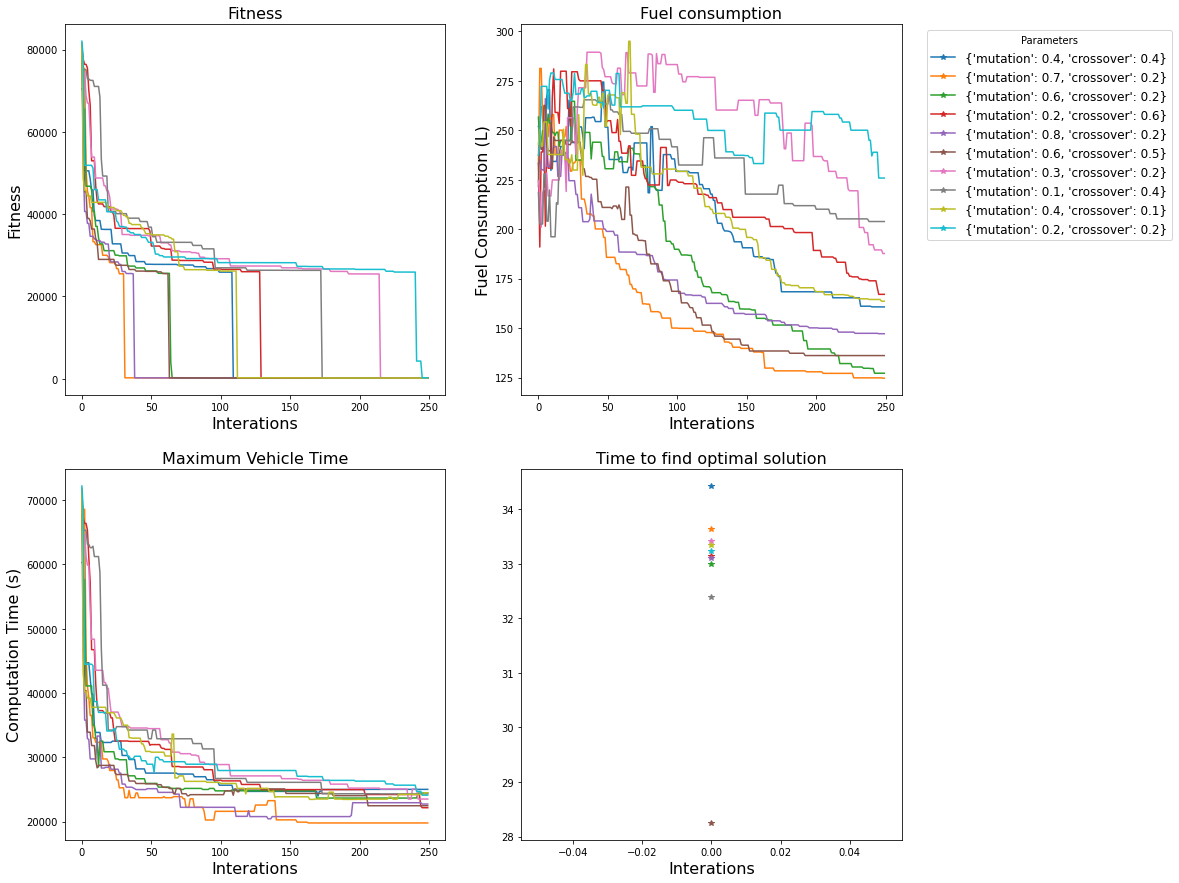

In [144]:
from matplotlib.font_manager import FontProperties
fig,axs = plt.subplots(ncols=2,nrows=2,figsize=(15,15))

for paramResult in best20ParamResults[:10]:
    axs[0][0].plot(np.mean(paramResult['results']['fitness'],axis=0),label=paramResult["parameters"])
    axs[0][1].plot(np.mean(paramResult['results']['fuel_consumption'],axis=0),label=paramResult["parameters"])
    axs[1][0].plot(np.mean(paramResult['results']['maxDriveTimes'],axis=0),label=paramResult["parameters"])
    axs[1][1].plot(paramResult['results']['optimal_time'],marker="*",label=paramResult["parameters"])


axs[0][0].set_title("Fitness",fontsize=16)
axs[0][1].set_title("Fuel consumption",fontsize=16)
axs[1][0].set_title("Maximum Vehicle Time",fontsize=16)
axs[1][1].set_title("Time to find optimal solution",fontsize=16)    

axs[0][0].set_xlabel("Interations",fontsize=16)
axs[0][0].set_ylabel("Fitness",fontsize=16)

axs[0][1].set_xlabel("Interations",fontsize=16)
axs[0][1].set_ylabel("Fuel Consumption (L)",fontsize=16)

axs[1][0].set_xlabel("Interations",fontsize=16)
axs[1][0].set_ylabel("Computation Time (s)",fontsize=16)


axs[1][1].set_xlabel("Interations",fontsize=16)
axs[1][0].set_ylabel("Computation Time (s)",fontsize=16)
fontP = FontProperties()
fontP.set_size('xx-small')
plt.legend( title='Parameters', bbox_to_anchor=(1.05, 2.2), loc='upper left',fontsize=12)

In [116]:
get_results(front_HYPE[0].path,problem_HYPE.distance_matrix,station_data,meta_data,time_matrix_here)

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Hao et al.),Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),Total Estimated Fuel Consumption (L) (Rakha et al.),Avg Estimated Fuel Conspumtion (L/100km) (Rakha et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,288.481,3453,38.048167,13.189141,27.055267,9.378527,62.396756,16644,04:37:24.00
1,223.850,3149,29.880131,13.348283,19.901674,8.890629,49.433198,16302,04:31:42.00
2,339.555,2271,45.091801,13.279675,31.196238,9.187389,60.637829,20159,05:35:59.00
3,283.412,2549,36.887303,13.015434,24.773863,8.741289,46.501217,21941,06:05:41.00
4,375.401,1332,48.238442,12.849844,34.577928,9.210931,59.490408,22717,06:18:37.00
5,368.785,2771,49.260342,13.357469,34.241893,9.285056,57.979998,22898,06:21:38.00
6,234.822,1949,30.225109,12.871498,21.982776,9.361464,66.261107,12758,03:32:38.00


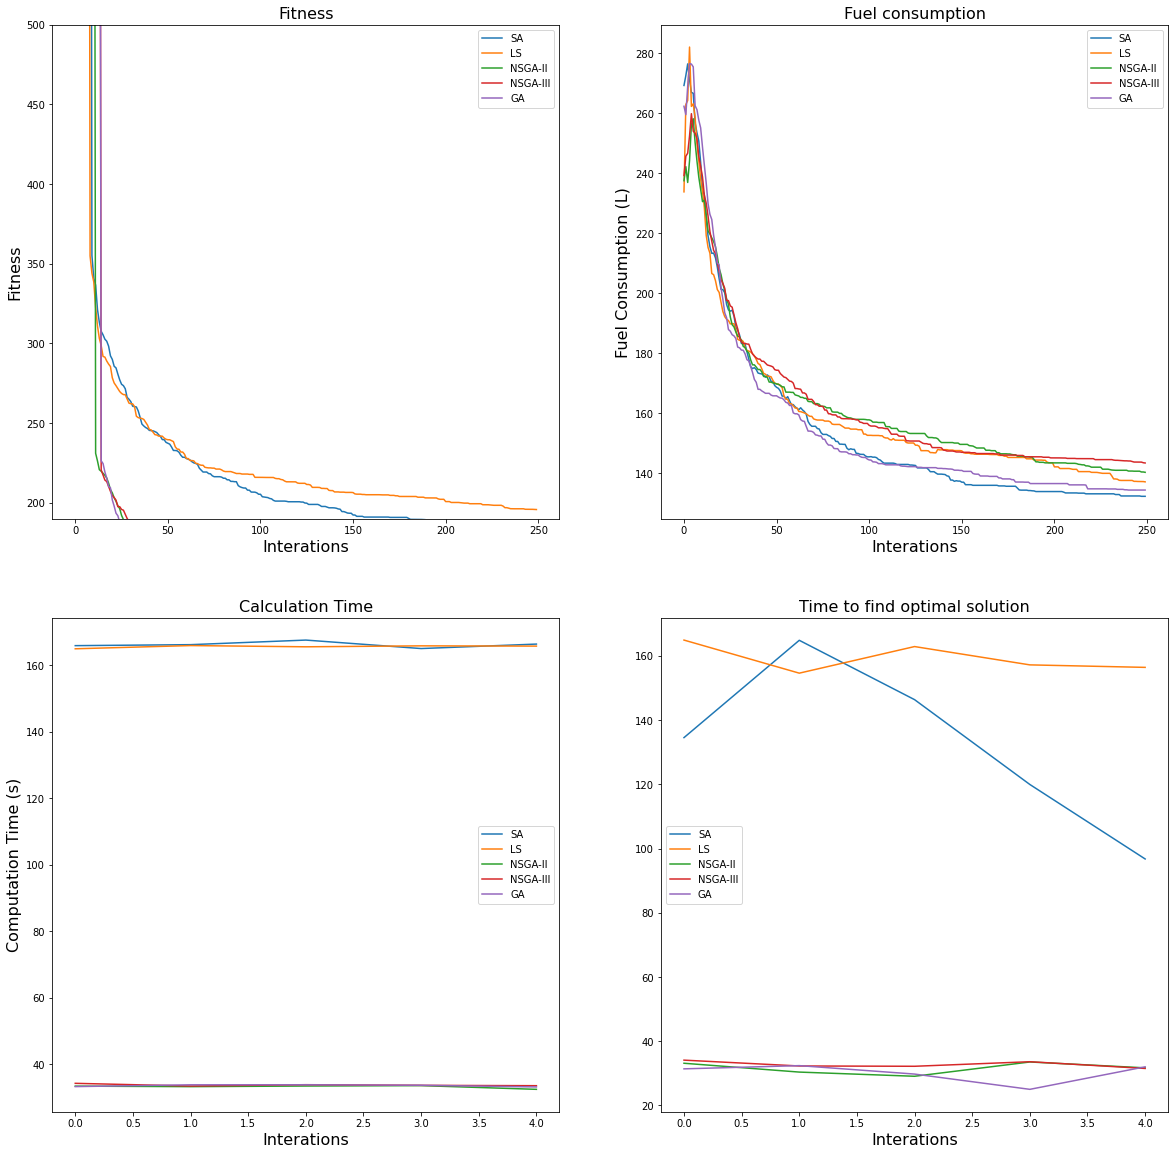

In [68]:

fig ,axs = plt.subplots(ncols=2,nrows=2,figsize=(20,20))
if performance_observer_SA != None: 
    axs[0][0].plot(np.mean(plot_data_SA['fitness'],axis=0),label='SA')
    axs[0][1].plot(np.mean(plot_data_SA['fuel_consumption'],axis=0),label='SA')
    axs[1][0].plot(plot_data_SA['computation_time'],label='SA')
    axs[1][1].plot(plot_data_SA['optimal_time'],label='SA')
if performance_observer_LS != None:
    axs[0][0].plot(np.mean(plot_data_LS['fitness'],axis=0),label='LS')
    axs[0][1].plot(np.mean(plot_data_LS['fuel_consumption'],axis=0),label='LS')
    axs[1][0].plot(plot_data_LS['computation_time'],label='LS')
    axs[1][1].plot(plot_data_LS['optimal_time'],label='LS')
if performance_observer_NSGAII != None:
    axs[0][0].plot(np.mean(plot_data_NSGAII['fitness'],axis=0),label='NSGA-II')
    axs[0][1].plot(np.mean(plot_data_NSGAII['fuel_consumption'],axis=0),label='NSGA-II')
    axs[1][0].plot(plot_data_NSGAII['computation_time'],label='NSGA-II')
    axs[1][1].plot(plot_data_NSGAII['optimal_time'],label='NSGA-II')
if performance_observer_NSGAIII != None:
    axs[0][0].plot(np.mean(plot_data_NSGAIII['fitness'],axis=0),label='NSGA-III')
    axs[0][1].plot(np.mean(plot_data_NSGAIII['fuel_consumption'],axis=0),label='NSGA-III')
    axs[1][0].plot(plot_data_NSGAIII['computation_time'],label='NSGA-III')
    axs[1][1].plot(plot_data_NSGAIII['optimal_time'],label='NSGA-III')
if performance_observer_GA != None:
    axs[0][0].plot(np.mean(plot_data_GA['fitness'],axis=0),label='GA')
    axs[0][1].plot(np.mean(plot_data_GA['fuel_consumption'],axis=0),label='GA')
    axs[1][0].plot(plot_data_GA['computation_time'],label='GA')
    axs[1][1].plot(plot_data_GA['optimal_time'],label='GA')
    
axs[0][0].set_title("Fitness",fontsize=16)
axs[0][1].set_title("Fuel consumption",fontsize=16)
axs[1][0].set_title("Calculation Time",fontsize=16)
axs[1][1].set_title("Time to find optimal solution",fontsize=16)    

axs[0][0].set_xlabel("Interations",fontsize=16)
axs[0][0].set_ylabel("Fitness",fontsize=16)

axs[0][1].set_xlabel("Interations",fontsize=16)
axs[0][1].set_ylabel("Fuel Consumption (L)",fontsize=16)

axs[1][0].set_xlabel("Interations",fontsize=16)
axs[1][0].set_ylabel("Computation Time (s)",fontsize=16)


axs[1][1].set_xlabel("Interations",fontsize=16)
axs[1][0].set_ylabel("Computation Time (s)",fontsize=16)
axs[0][0].set_ylim(top=500,bottom=190)
#axs[1][0].set_yscale('log')
#axs[1][1].set_yscale('log')
for ax_row in axs:
    for ax in ax_row:
        ax.legend()
plt.show()

In [74]:
#plot_data = [final_results_SA,final_results_LS,final_results_NSGAIII,final_results_NSGAII,final_results_GA]
final_data = [final_results_NSGAIII,final_results_NSGAII,final_results_GA]

#names = ["Final_SA","Final_LS","Final_NSGAIII","Final_NSGAII","Final_GA"]
names = ["Final_NSGAIII","Final_NSGAII","Final_GA"]
dataPath = "../logs/2021-02-11/JMetal-50-Nodes-Best-Selector/Total_Fuel_Endpoints_Not_set/"

for data, name in zip(final_data,names):
    DF = pd.DataFrame(data)
    DF.to_csv("{}{}.csv".format(dataPath,name),index=False)

In [75]:
#plot_data = [plot_data_SA,plot_data_LS,plot_data_NSGAIII,plot_data_NSGAII,plot_data_GA]
plot_data = [plot_data_NSGAIII,plot_data_NSGAII,plot_data_GA]
#names = ["Observer_SA","Observer_LS","Observer_NSGAIII","Observer_NSGAII","Observer_GA"]
names = ["Observer_NSGAIII","Observer_NSGAII","Observer_GA"]
dataPath = "../logs/2021-02-11/JMetal-50-Nodes-Best-Selector/Total_Fuel_Endpoints_Not_set/"

for data, name in zip(plot_data,names):
    DF = pd.DataFrame(data)
    DF.to_csv("{}{}.csv".format(dataPath,name),index=False)

In [143]:
algoritm_observers = [performance_observer_SA,performance_observer_LS,performance_observer_GA,performance_observer_NSGAII,performance_observer_NSGAIII]
types =["JMetalPy-SA","LS","GA","NSGAII","NSGAIII"]
metrics = ["Fitness","Fuel Consumption","Computation Time"]#,"DeltaTime"]
columns = []
data = []

for algoType in types:
    for metric in metrics:
        columns.append("{}-{}".format(algoType,metric))

for observer in  algoritm_observers:
    for index in range(len(observer.performances)):
        data.append([observer.performances[index],observer.total_consumptions[index],observer.computing_times[index]])

    
np_data = np.array(data)
np_data= np_data.reshape((250,15))

df_data = pd.DataFrame(np_data,columns=columns)

df_data
df_data.to_csv("../logs/2021-02-09/11_54_JMetalPy_50_1.csv",index=False)

ValueError: cannot reshape array of size 1050 into shape (250,15)

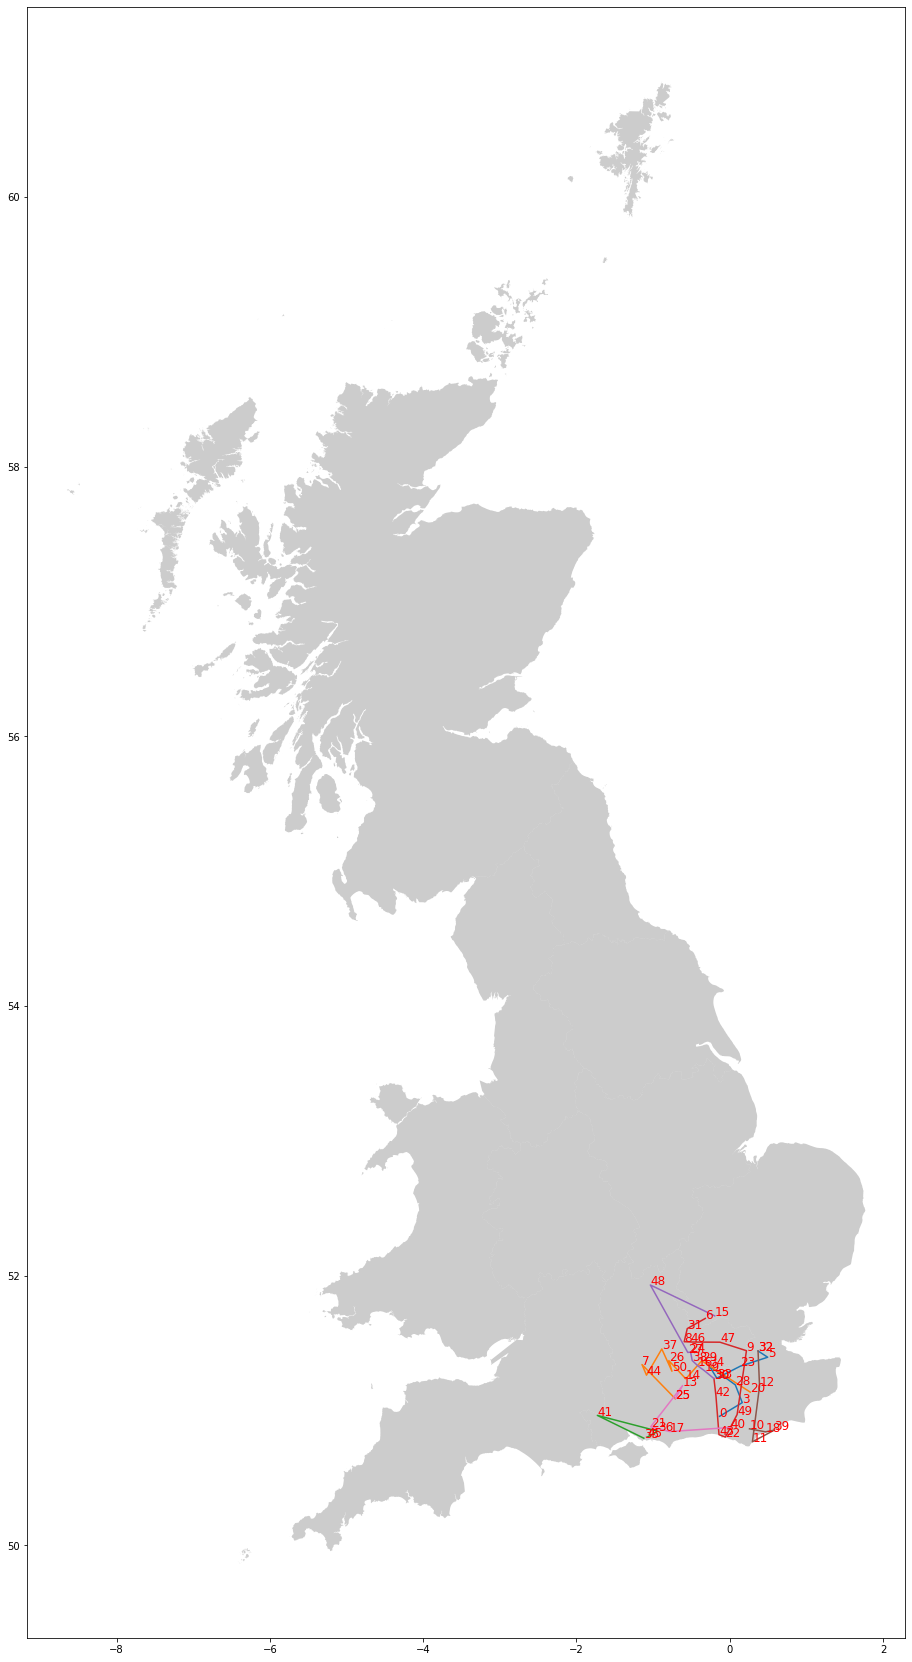

In [19]:
plot_routes(front_NSGAIII[0].path,points_coordinate,dbf,station_ids = True, here_api=False, api_key=api)

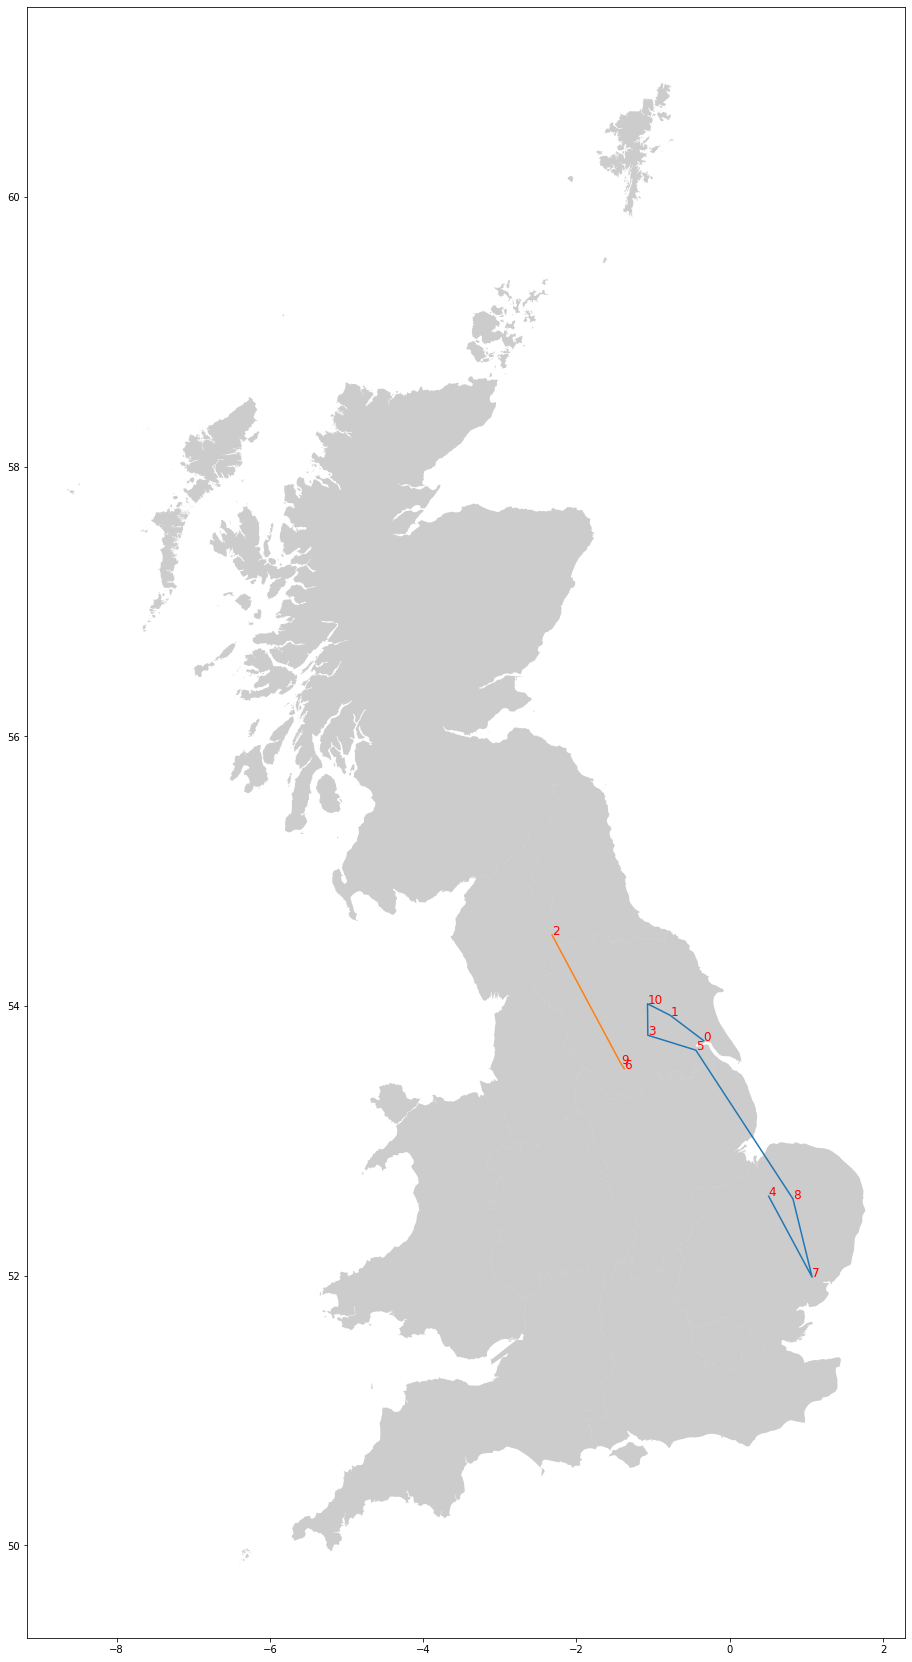

In [55]:
plot_routes(solutions_GA.path,points_coordinate,dbf,station_ids = True, here_api=False, api_key=api)

In [21]:
vehicle_routes = []
vehicle_stops = []
vehicle_stop_demands = []
for v_route in solutions_NSGAIII[0].path:
    vehicle_stop_demands.append(np.array(customer_demands)[v_route[1:]])
    vehicle_stops.append(points_coordinate[v_route[1:]])
    vehicle_routes.append(decode_routes(generate_routes(points_coordinate[v_route],api)))

100%|██████████| 4/4 [00:06<00:00,  1.70s/it]


In [22]:
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

In [28]:
import folium
from folium.plugins import PolyLineTextPath
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

centerpoint = [np.mean(points_coordinate[:,0]),np.mean(points_coordinate[:,1])]

folium_map = folium.Map(location=centerpoint, tiles='openstreetmap', zoom_start=8)

# Create popups for the pickup-points
position_popups = []
for solution_path,stop_demands in zip(solutions_NSGAIII[0].path,vehicle_stop_demands):
    position_popups.append(["Node: {}\nDemand: {}(kg)".format(node_id,node_demand) for node_id,node_demand in zip(solution_path[1:],stop_demands)])


markerCluster = MarkerCluster().add_to(folium_map)
# Add pickup-points and start positions to map
for startPos,stop_demands,stop_pos in zip(starts,position_popups,vehicle_stops):
    folium.Marker(location=list(points_coordinate[startPos]),popup="Startpos\nNode: {}".format(startPos),icon=folium.Icon(color='red', icon_color='white', icon='truck', angle=0, prefix='fa')).add_to(markerCluster)
    if len(stop_pos)>1:

        MarkerCluster(stop_pos[:-1],popups=stop_demands[:-1]).add_to(folium_map)
        folium.Marker(location=list(stop_pos[-1]),popup="End\n{}".format(stop_demands[-1]),
                      icon=folium.Icon(color='green', icon_color='white', icon='flag-checkered', angle=0, prefix='fa')).add_to(markerCluster)
        
    else:
        folium.Marker(location=list(stop_pos[0]),popup="{}".format(stop_demands[0]),
                      icon=folium.Icon(color='red', icon_color='white', icon='exclamation-circle', angle=0, prefix='fa')).add_to(markerCluster)
        

colormap = folium.branca.colormap.LinearColormap(colors=['red','green', 'blue'],index=[0,int(len(vehicle_routes)/2),len(vehicle_routes)])
# Add routes to map with popups
for index,(route,route_load,route_fuel_consumption, route_distance) in enumerate(zip(vehicle_routes,solutions_NSGAIII[0].vehicle_loads,
                                                                                     solutions_NSGAIII[0].vehicle_fuel_consumptions,solutions_NSGAIII[0].vehicle_route_distances)):
    
    if(len(route) > 1):
        line = folium.PolyLine(route,color=colormap(index),
                               popup="Route Load: {}(kg)\nFuel consumption: {}(L)\nDistance: {}(km)".format(route_load,route_fuel_consumption,round(route_distance/1000,2))).add_to(folium_map)
        PolyLineTextPath(line, "\u27A4    ",repeat=True).add_to(folium_map)        

# Display the map
folium_map